In [1]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, _kmeans, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *
from funcs_characterise import *
from paths import *

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
study_name = 'n_clusters'
data_path = Path(f'data_egfr/msm/{study_name}')
summary_f = data_path/f'{study_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

summary = raw.groupby('hp_id')[['t2', 'gap_2', 't3', 'gap_3']].agg(['mean', 'std'])
summary

t2                   gap_2                        t3  \
               mean           std      mean        std           mean   
hp_id                                                                   
0      4.258766e+06  4.993950e+06  9.877259  10.570731  438539.507225   
1      2.927477e+06  3.859451e+06  7.083355   7.666884  420395.265777   
2      3.770089e+06  5.647987e+06  8.087046  10.971600  476668.578812   
3      3.775350e+06  5.297374e+06  7.257305   8.182101  513894.618174   

                         gap_3            
                 std      mean       std  
hp_id                                     
0      340220.880011  2.368782  1.164973  
1      355997.202171  2.458528  1.548529  
2      398473.507520  2.461085  1.242254  
3      397912.479254  2.509716  1.214368

In [3]:
hp_id = 0
hp_dict = Adict(hps[hps.hp_id == hp_id].to_dict('records')[0])
features = ['dbdist', 'dbdihed', 'aloop', 'ploopdihed', 'achelix']

savedir = Path(f'data_egfr/msm/validation/{study_name}_hp{hp_id}_validate')
savedir.mkdir(exist_ok=True, parents=True)

hp_dict

{'hp_id': 0,
 'trajlen__cutoff': 1000,
 'n__boot': 20,
 'seed': 49587,
 'tica__lag': 10,
 'tica__stride': 1000,
 'tica__dim': 20,
 'cluster__k': 1000,
 'cluster__stride': 1000,
 'cluster__maxiter': 1000,
 'markov__lag': 100}

In [11]:
pcca_membership = np.load(savedir/'pcca_memberships.npy')
data = np.load(savedir/'index_states.npz')
index_states = [data[arr] for arr in data.files]

In [15]:
dssp_trajs, traj_mapping = get_data(trajlen_cutoff=hp_dict.trajlen__cutoff, features=['aloopdssp', 'achelixdssp'], ftraj_dir=ftraj_dir)

Loading feature:  aloopdssp


100%|██████████| 3472/3472 [01:00<00:00, 57.10it/s]


Loading feature:  achelixdssp


100%|██████████| 3472/3472 [00:46<00:00, 74.70it/s] 

Loaded number of ftrajs: 1988


In [33]:
state_al_dssp_prob = []
state_ac_dssp_prob = []

for state_i in range(6):
    membership_cutoff = 0.9  
    memberships = pcca_membership[:,state_i]
    states_to_sample = memberships > membership_cutoff
    filtered_index_states = np.concatenate([item for item, use in zip(index_states, states_to_sample) if use], axis=0)
    
    al_dssp = [dssp_trajs[indices[0]][indices[1], :23] for indices in filtered_index_states]
    ac_dssp = [dssp_trajs[indices[0]][indices[1], 23:] for indices in filtered_index_states]

    state_al_dssp_prob.append((np.array(al_dssp) == 'H').mean(axis=0))
    state_ac_dssp_prob.append((np.array(ac_dssp) == 'H').mean(axis=0))

In [56]:
traj = md.load(savedir/'MS_1.pdb')
top = traj.topology

In [67]:
asp855_id = np.where([str(res) == 'ASP855' for res in top.residues])[0][0]
pro877_id = np.where([str(res) == 'PRO877' for res in top.residues])[0][0]
aloop_top = top.subset(top.select(f'resid {asp855_id} to {pro877_id}'))
aloop_label = [str(res) for res in aloop_top.residues]

In [65]:
LYS757_id = np.where([str(res) == 'LYS757' for res in top.residues])[0][0]
SER768_id = np.where([str(res) == 'SER768' for res in top.residues])[0][0]   
achelix_top = top.subset(top.select(f'resid {LYS757_id} to {SER768_id}'))   
achelix_label = [str(res) for res in achelix_top.residues]

In [113]:
ex = traj[0].atom_slice(top.select(f'resid {asp855_id} to {pro877_id}'))

In [116]:
ex.save(savedir/'aloop_raw.pdb')

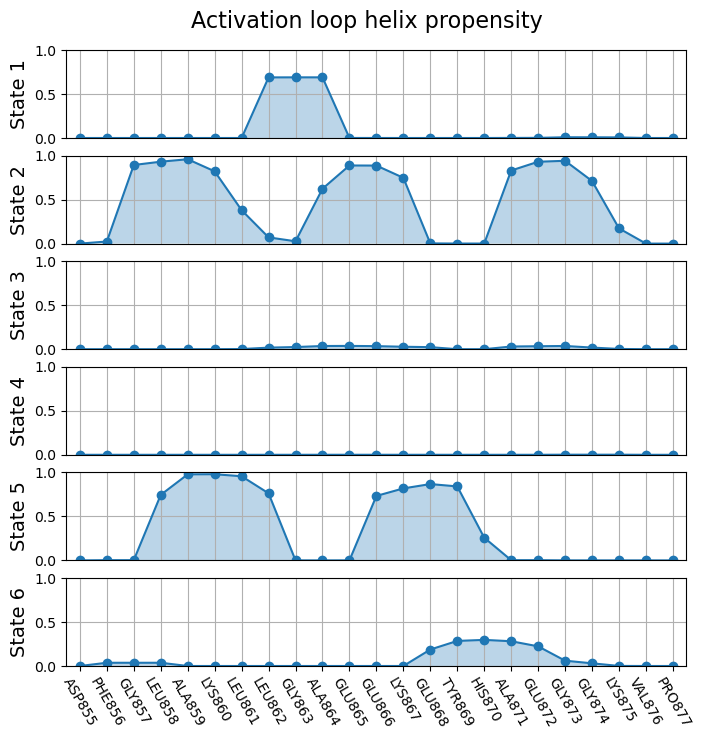

In [127]:
fig, axes = plt.subplots(6, 1, figsize=(8, 8))

for i, ax in enumerate(axes):
    ax.plot(state_al_dssp_prob[i], label='aloop', marker='o')
    ax.fill_between(np.arange(len(aloop_label)), state_al_dssp_prob[i], alpha=0.3)
    ax.set_ylim(0, 1)
    ax.set_xlim(-0.5, 22.5) 
    
    ax.set_xticks(np.arange(len(aloop_label)))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.grid(axis='both')

    ax.set_ylabel(f'State {i+1}', fontsize=14)

axes[5].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[5].set_xticks(np.arange(len(aloop_label)))
axes[5].set_xticklabels(aloop_label, rotation=-60)
fig.suptitle('Activation loop helix propensity', fontsize=16, y=0.93)

plt.savefig(savedir/'aloop_helix_propensity.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

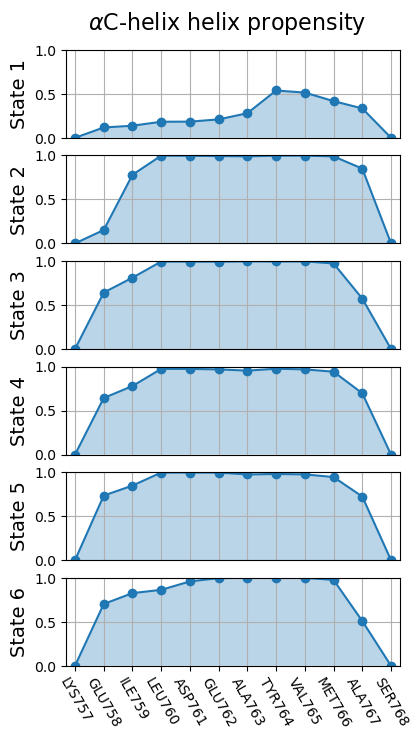

In [126]:
fig, axes = plt.subplots(6, 1, figsize=(4.3, 8))

for i, ax in enumerate(axes):
    ax.plot(state_ac_dssp_prob[i], label='aloop', marker='o')
    ax.fill_between(np.arange(len(achelix_label)), state_ac_dssp_prob[i], alpha=0.3)

    ax.set_ylim(0, 1)
    ax.set_xlim(-0.3, 11.3) 
    
    ax.set_xticks(np.arange(len(achelix_label)))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.grid(axis='both')
    
    ax.set_ylabel(f'State {i+1}', fontsize=14)

axes[5].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[5].set_xticks(np.arange(len(achelix_label)))
axes[5].set_xticklabels(achelix_label, rotation=-60)
fig.suptitle(r'$\alpha$C-helix helix propensity', fontsize=16, y=0.93)

plt.savefig(savedir/'achelix_helix_propensity.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()